In [ ]:
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 3.9 MB/s eta 0:00:00


In [ ]:
import os
os.environ['TORCH_LOGS_FORMAT'] = "%(message)s"
import torch



First, let's define our function. We will perform two pointwise operations and then compute the matmul with two weights w1 and w2.

Note that in this case, w1 and w2 will be closed over variables.


In [ ]:
w1 = torch.randn(64, 64)
w2 = torch.randn(64, 64)

def f(x):
    x = x.cos()
    x = x.sin()
    a = torch.mm(x, w1)
    b = torch.mm(x, w2)
    return a, b

x = torch.randn(32, 64)
output = torch.compile(f)(x)
output2 = f(x)

Now, let's see the graph format that torch.compile captures and passes to Inductor. This can be normally be done by setting the environmental variable `TORCH_LOGS="aot_graphs"`, but we will manually set the logging here in the notebook.

In [ ]:
x = torch.randn(32, 64)
torch._logging.set_logs(aot_graphs=True)

res = torch.compile(f)(x)

Note that we can also get the graph called in the backwards pass. Just like with normal Pytorch semantics, this is accomplished whenever we need to perform backpropagation.

In [ ]:
x = torch.randn(32, 64, requires_grad=True)
torch._logging.set_logs(aot_graphs=True)

res = torch.compile(f)(x)

aot_config id: 1, fw_metadata=ViewAndMutationMeta(input_info=[InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=True, keep_input_mutations=True), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=True), InputAliasInfo(is_leaf=True, mutates_data=False, mutates_metadata=False, mutations_hidden_from_autograd=True, mutations_under_no_grad_or_inference_mode=False, mutation_inductor_storage_resize=False, mutates_storage_metadata=False, requires_grad=False, keep_input_mutations=True)], output_info=[OutputAliasInfo(output_type=<OutputType.non_alias: 1>, raw_type=<class 'torch._subcla

Now, let's look at the generated output code. You should see a `cpp_fused_cos_sin_0` kernel, which contains the loops for the generated pointwise function.

In addition, if you scroll down, you should also see a `call(args)` function. This is the "wrapper" function that actually chains all the kernels together.

Finally, you should also see several `extern_kernels.mm` calls - these are the cases where Inductor falls back to a pre-existing kernel, like in the case of matmuls.

In [ ]:
x = torch.randn(32, 64)
torch._logging.set_logs(output_code=True)
torch._dynamo.reset()

res = torch.compile(f)(x)

Output code written to: /tmp/torchinductor_root/6s/c6szshunbyms7k4kgiwzeiscgbkhdq4cgj3rmlnanjbwfy2rp347.py
Output code: 
# AOT ID: ['0_inference']
from ctypes import c_void_p, c_long, c_int
import torch
import math
import random
import os
import tempfile
from math import inf, nan
from torch._inductor.hooks import run_intermediate_hooks
from torch._inductor.utils import maybe_profile
from torch._inductor.codegen.memory_planning import _align as align
from torch import device, empty_strided
from torch._inductor.async_compile import AsyncCompile
from torch._inductor.select_algorithm import extern_kernels
from torch._inductor.codegen.multi_kernel import MultiKernelCall

aten = torch.ops.aten
inductor_ops = torch.ops.inductor
_quantized = torch.ops._quantized
assert_size_stride = torch._C._dynamo.guards.assert_size_stride
empty_strided_cpu = torch._C._dynamo.guards._empty_strided_cpu
empty_strided_cuda = torch._C._dynamo.guards._empty_strided_cuda
empty_strided_xpu = torch._C._dynamo.guards

# Lowering a custom operator

First we define a custom operator implementing a conversion from jagged tensor to a dense tensor with added padding.

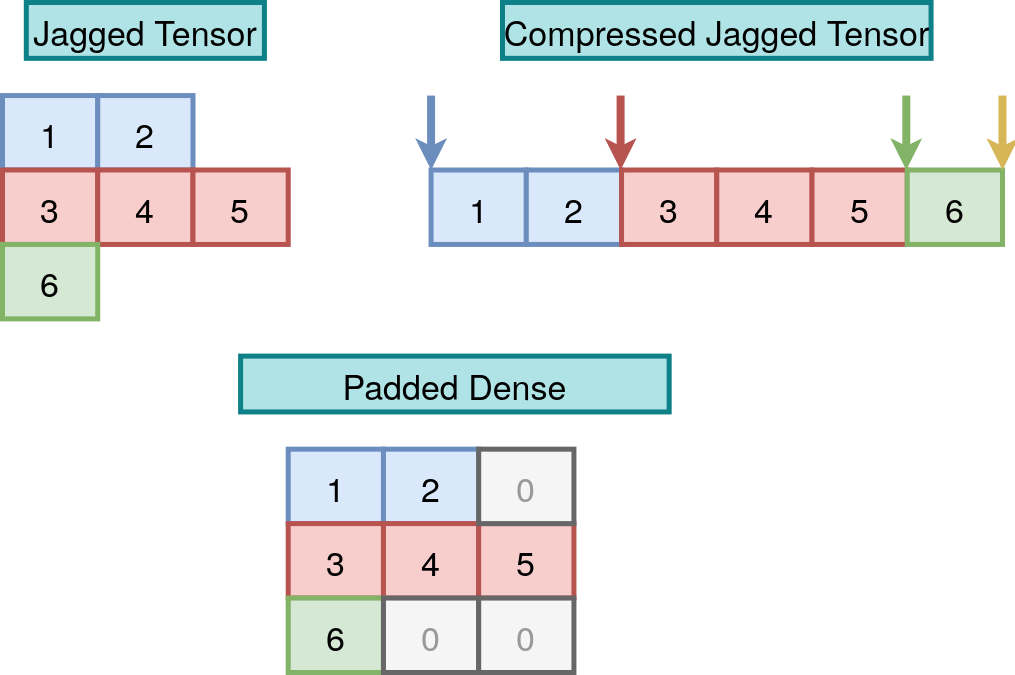

In [ ]:
import torch


jagged_lib = torch.library.Library("jagged", "DEF")
jagged_lib.define(
    "jagged_to_padded_dense(Tensor input, Tensor offsets, SymInt max_seq_len, Scalar pad_value) -> Tensor"
)
jagged_impl = torch.library.Library(
    "jagged", "IMPL", "CompositeExplicitAutograd"
)
jagged_meta = torch.library.Library(
    "jagged", "IMPL", "Meta"
)

def j2pd_meta(inp, offsets, max_seq_len, pad_value):
    return torch.empty(
    (offsets.shape[0] - 1, max_seq_len),
    device=inp.device,
    dtype=inp.dtype,
)

def j2pd_impl(inp, offsets, max_seq_len, pad_value):
    res = torch.full(
        (offsets.shape[0] - 1, max_seq_len),
        pad_value,
        device=inp.device,
        dtype=inp.dtype,
    )
    for b in range(offsets.shape[0] - 1):
        begin = offsets[b]
        end = offsets[b + 1]

        res[b][:end - begin] = inp[begin:end]
    return res



jagged_impl.impl("jagged_to_padded_dense", j2pd_impl)
jagged_meta.impl("jagged_to_padded_dense", j2pd_meta)

We can see how this works by running a small example

In [ ]:
inp = torch.tensor([1, 2, 3, 4, 5, 6])
offsets = torch.tensor([0, 2, 5, 6])
max_seq_len = 3
pad_value = 0
torch.ops.jagged.jagged_to_padded_dense(inp, offsets, max_seq_len, pad_value)

tensor([[1, 2, 0],
        [3, 4, 5],
        [6, 0, 0]])

Now we implement a lowering to inductor IR

In [ ]:
from torch._inductor.ir import Pointwise
from torch._inductor.lowering import register_lowering
from torch._inductor.virtualized import ops


@register_lowering(
    torch.ops.jagged.jagged_to_padded_dense, type_promotion_kind=None
)
def j2pd_lowering(inp, offsets, max_seq_len, pad_value):
    offsets_loader = offsets.make_loader()
    inp_loader = inp.make_loader()
    jagged_len = inp.get_size()[0]
    offsets_dtype = offsets.get_dtype()

    def inner_fn(index):
        batch_idx, seq_idx = index

        begin_idx = ops.indirect_indexing(
            offsets_loader([batch_idx]),
            jagged_len + 1,
        )
        end_idx = offsets_loader([batch_idx + 1])
        jagged_idx = begin_idx + seq_idx

        mask = ops.lt(
            ops.index_expr(jagged_idx, offsets_dtype),
            end_idx,
        )

        return ops.masked(mask, lambda: inp_loader([jagged_idx]), pad_value)

    return Pointwise.create(
        device=inp.get_device(),
        dtype=inp.get_dtype(),
        inner_fn=inner_fn,
        ranges=[offsets.get_size()[0] - 1, max_seq_len],
    )

With this we see significant speedups compared to the eager pytorch implentation

In [ ]:
ssizes = torch.arange(1024)
offsets = torch.cumsum(ssizes, dim=0)

inp = torch.randn(ssizes.sum().item())
max_seq_len = 1024
pad_value = 0.0

j2pd = torch.ops.jagged.jagged_to_padded_dense
compiled_j2pd = torch.compile(j2pd)
torch.testing.assert_close(
    j2pd(inp, offsets, max_seq_len, pad_value),
    compiled_j2pd(inp, offsets, max_seq_len, pad_value)
)

print("Eager runtime")
%timeit j2pd(inp, offsets, max_seq_len, pad_value)

# Run once to warmup cache
%timeit compiled_j2pd(inp, offsets, max_seq_len, pad_value)
print("Compiled runtime")
%timeit compiled_j2pd(inp, offsets, max_seq_len, pad_value)

Output code: 
# AOT ID: ['3_inference']
from ctypes import c_void_p, c_long, c_int
import torch
import math
import random
import os
import tempfile
from math import inf, nan
from torch._inductor.hooks import run_intermediate_hooks
from torch._inductor.utils import maybe_profile
from torch._inductor.codegen.memory_planning import _align as align
from torch import device, empty_strided
from torch._inductor.async_compile import AsyncCompile
from torch._inductor.select_algorithm import extern_kernels
from torch._inductor.codegen.multi_kernel import MultiKernelCall

aten = torch.ops.aten
inductor_ops = torch.ops.inductor
_quantized = torch.ops._quantized
assert_size_stride = torch._C._dynamo.guards.assert_size_stride
empty_strided_cpu = torch._C._dynamo.guards._empty_strided_cpu
empty_strided_cuda = torch._C._dynamo.guards._empty_strided_cuda
empty_strided_xpu = torch._C._dynamo.guards._empty_strided_xpu
reinterpret_tensor = torch._C._dynamo.guards._reinterpret_tensor
alloc_from_pool = torc

Eager runtime
20.6 ms ± 569 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
712 µs ± 146 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Compiled runtime
603 µs ± 8.01 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Graph Transforms
Now, let's show how you might integrate a custom graph transformation.

In [ ]:
import torch._inductor.config as config

In [ ]:
def f(x):
  x = torch.mm(x, x)
  x = x ** 2
  x = torch.cos(x)
  return x

In [ ]:
def custom_print_pass(fx_graph):
  print("Custom pass run!", fx_graph)
  return fx_graph

config.post_grad_custom_post_pass = custom_print_pass

In [ ]:
_ = torch.compile(f)(torch.randn(20, 20))
torch._dynamo.reset()

Output code: 
# AOT ID: ['4_inference']
from ctypes import c_void_p, c_long, c_int
import torch
import math
import random
import os
import tempfile
from math import inf, nan
from torch._inductor.hooks import run_intermediate_hooks
from torch._inductor.utils import maybe_profile
from torch._inductor.codegen.memory_planning import _align as align
from torch import device, empty_strided
from torch._inductor.async_compile import AsyncCompile
from torch._inductor.select_algorithm import extern_kernels
from torch._inductor.codegen.multi_kernel import MultiKernelCall

aten = torch.ops.aten
inductor_ops = torch.ops.inductor
_quantized = torch.ops._quantized
assert_size_stride = torch._C._dynamo.guards.assert_size_stride
empty_strided_cpu = torch._C._dynamo.guards._empty_strided_cpu
empty_strided_cuda = torch._C._dynamo.guards._empty_strided_cuda
empty_strided_xpu = torch._C._dynamo.guards._empty_strided_xpu
reinterpret_tensor = torch._C._dynamo.guards._reinterpret_tensor
alloc_from_pool = torc

Custom pass run! graph():
    %arg0_1 : [num_users=1] = placeholder[target=arg0_1]
    %mm : [num_users=1] = call_function[target=torch.ops.aten.mm.default](args = (%arg0_1, %arg0_1), kwargs = {})
    %pow_1 : [num_users=1] = call_function[target=torch.ops.aten.pow.Tensor_Scalar](args = (%mm, 2), kwargs = {})
    %cos : [num_users=1] = call_function[target=torch.ops.aten.cos.default](args = (%pow_1,), kwargs = {})
    return (cos,)


Output code written to: /tmp/torchinductor_root/aa/caaslpaaqiwxztwtikyqzbx3xjjjadiex7ql6u4mfwpy4a5pltgt.py


In [ ]:
def strength_reduce_pow(fx_graph):
  for node in fx_graph.nodes:
    if node.target == torch.ops.aten.pow.Tensor_Scalar and node.args[1] == 2:
      # Replace pow(x, 2) with x * x
      node.target = torch.ops.aten.mul.Scalar
      node.args = (node.args[0], node.args[0])
  print("transformed graph!")
  print(fx_graph)
  return fx_graph

In [ ]:
config.post_grad_custom_post_pass = strength_reduce_pow

In [ ]:
_ = torch.compile(f)(torch.randn(20, 20))
torch._dynamo.reset()

transformed graph!
graph():
    %arg0_1 : [num_users=1] = placeholder[target=arg0_1]
    %mm : [num_users=1] = call_function[target=torch.ops.aten.mm.default](args = (%arg0_1, %arg0_1), kwargs = {})
    %pow_1 : [num_users=1] = call_function[target=torch.ops.aten.mul.Scalar](args = (%mm, %mm), kwargs = {})
    %cos : [num_users=1] = call_function[target=torch.ops.aten.cos.default](args = (%pow_1,), kwargs = {})
    return (cos,)


BackendCompilerFailed: backend='inductor' raised:
RuntimeError: aten::mul() Expected a value of type 'number' for argument 'other' but instead found type 'FakeTensor'.
Position: 1
Value: FakeTensor(..., size=(20, 20))
Declaration: aten::mul.Scalar(Tensor self, Scalar other) -> Tensor
Cast error details: Cannot cast FakeTensor(..., size=(20, 20)) to number

Set TORCH_LOGS="+dynamo" and TORCHDYNAMO_VERBOSE=1 for more information


You can suppress this exception and fall back to eager by setting:
    import torch._dynamo
    torch._dynamo.config.suppress_errors = True
